# Homework 4 - 2305

*   Tommaso Bertola 2086990
*    Giacomo Di Prima 2086992
*    Giuseppe Viterbo 2086516
*    Marzo Zenari 2097012



In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#XGBoost
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import graphviz
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

#Neural Networks
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow.random as tf_r

tf_r.set_seed(123)
plt.rcParams['font.size'] = 15

XGBoost version: 1.7.5


## Generation of the data and plot

Generates the data to be used for the training and the test of two algorithms: XGBoost and Neural Network. The data are labeled in two categories and have two features.

In [2]:
def gen_data(CASE, N, perc_train, S=2):
    np.random.seed(123)
    #Number of sammples for training and test
    N_train = int(N*perc_train) 
    N_test  = N - N_train
    #Sampling the feature
    x = S*(2*np.random.rand(N,2)-1)
    #Assigning the labels
    y = np.zeros(N) # float
    for n in range(N):
        if CASE==0:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==1:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
                
    if CASE == 2:
        y[(x.T[0]+1.)**2 + (x.T[1]-1.)**2 < 0.45] = 1
        
        mask1 = -x.T[0] - 2 > x.T[1]
        mask2 = -x.T[0] - 2.5 < x.T[1]
        mask3 = x.T[0]>-2
        mask4 = x.T[0]<-0.5
        
        y[mask1 & mask2 & mask3 & mask4] = 1
        
        mask5= x.T[0]>0
        y[mask5]=1
        
        mask6 = -(x.T[0]-2)**2 +1.75 > x.T[1]
        mask7 = x.T[1] > 0
        y[mask6 & mask7] = 0
        
    #Dividing the data in two sets          
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('N:', N, 'N_train:', N_train, 'CASE:', CASE)
    return x_train, y_train, x_test, y_test
#function to plot the data
def plot_scatter(x, y, c_map='plasma', s=4):
    plt.scatter(x[:,0], x[:,1], c=y, cmap=c_map, s=s)

Generation and plot of the data

N: 10000 N_train: 8000 CASE: 2


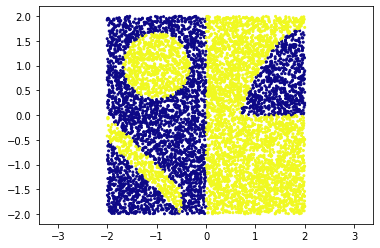

In [3]:
CASE=2
S=2
N=10000
perc_train=0.80
x_train, y_train, x_test, y_test = gen_data(CASE=2, N=N, perc_train=perc_train, S=S)

plt.figure(figsize=(6,4))
plot_scatter(x_train, y_train)
plt.axis('equal')
plt.show()

# 1) XGB vs NN

Training the two models: XGBoost and Feed Forward Neural Network and compairing the results.

## Classifier: XGB

In [4]:
#Defining the function classify which trains the XGB

def classify(clf=XGBClassifier(),show=False):
    #train    
    clf.fit(x_train,y_train)
    #error on test set
    error_xgb=100*(1-clf.score(x_test, y_test)) 
    if show:
        print("errors: {:.2f}%".format(error_xgb))
    
    #Plot of the results
    dx = 0.04
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)
    
    if show:    
        plt.figure(figsize=(6,6))
        plt.title(str(clf))

        plot_scatter(x_plot,y_plot)
        plt.show()
    
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()
        
    return x_plot, y_plot, error_xgb

### Application of XGB to our data

Training the XGB on our data, plotting the predictions and plotting the decision trees obtained by the training of the algorithm.

errors: 4.95%


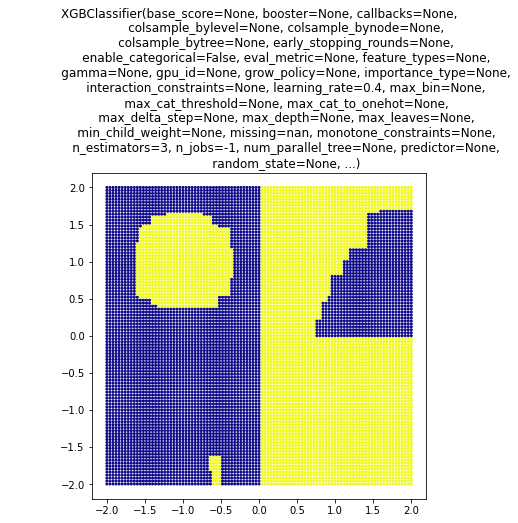

num_trees= 3


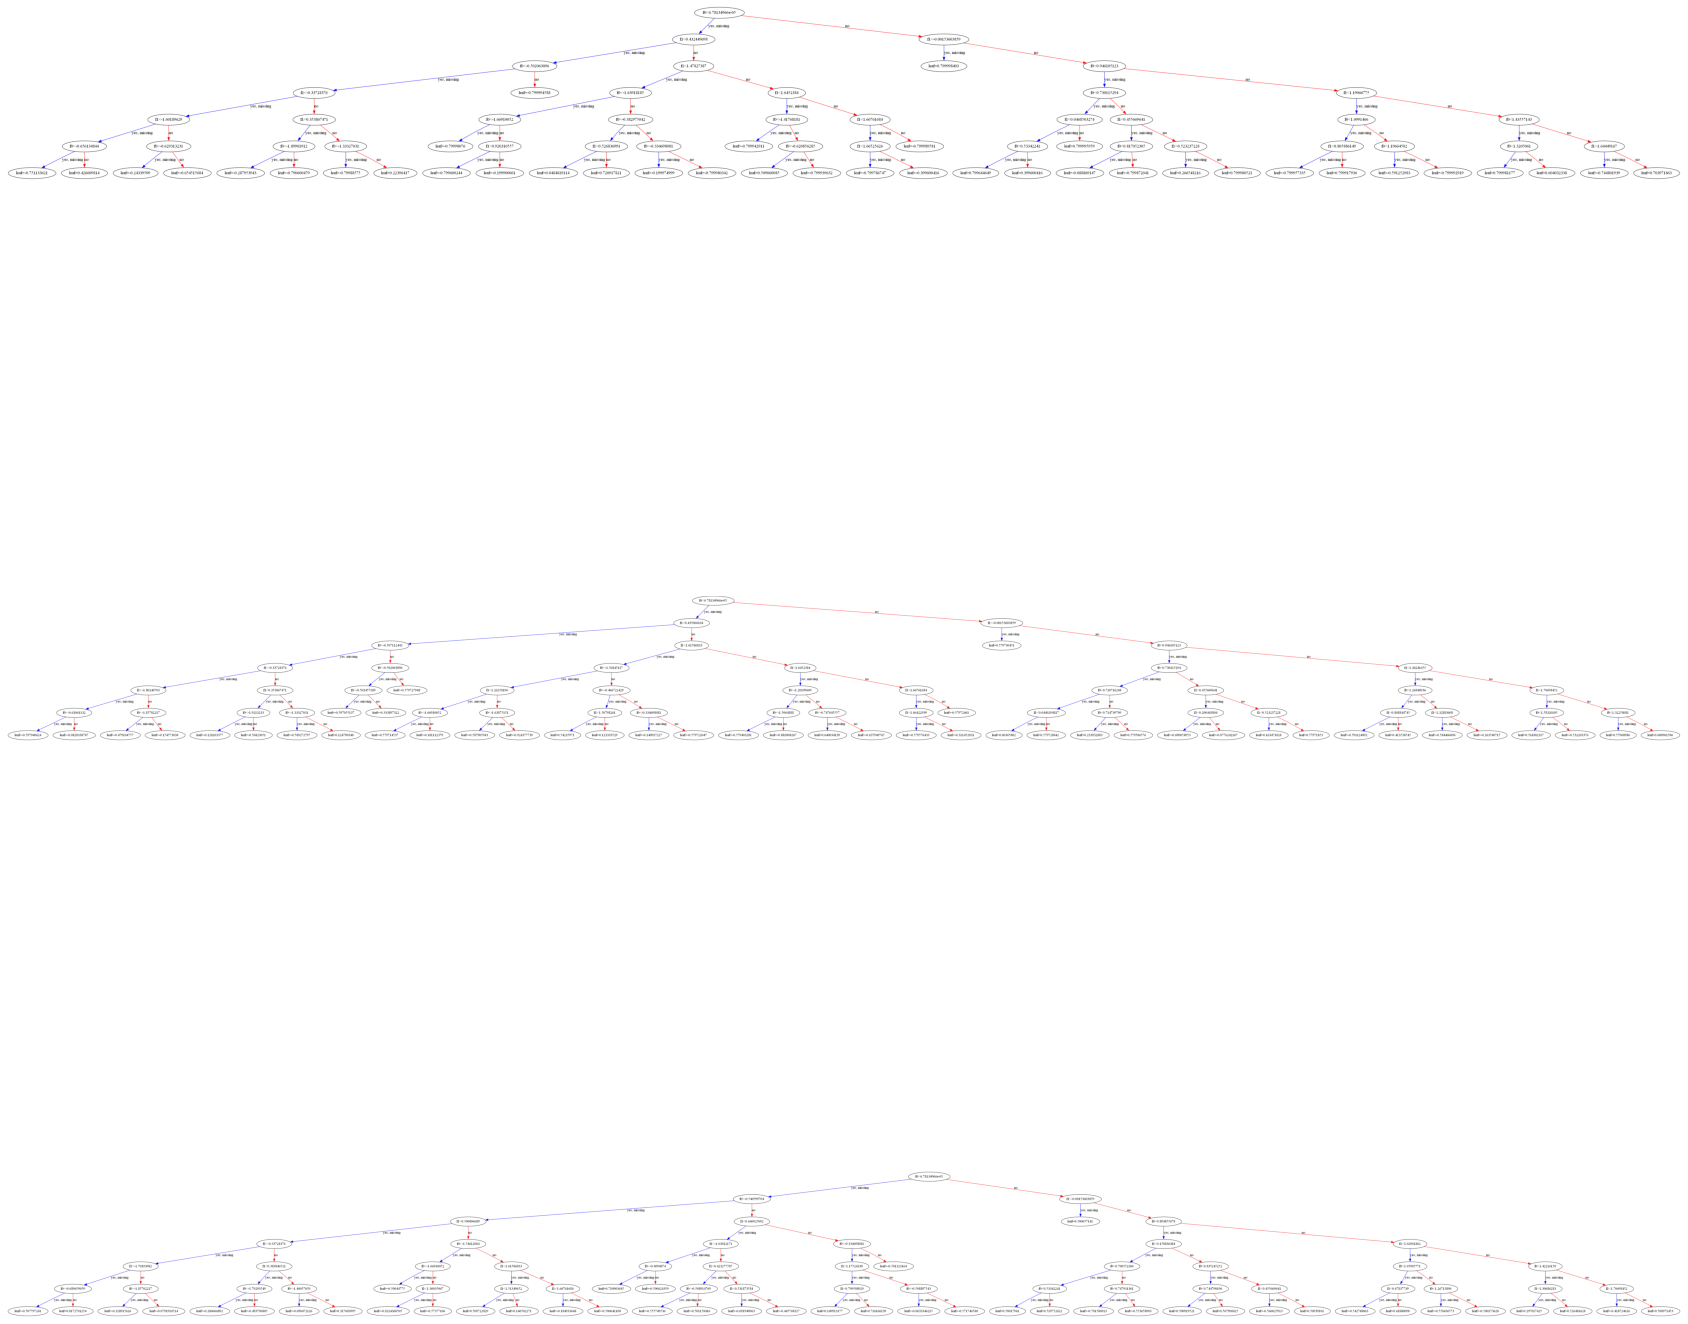

In [5]:
xg_x_plot, xg_y_plot, _=classify(XGBClassifier(seed=1,
                                               objective='binary:logistic',
                                               learning_rate=0.4,
                                               reg_lambda=0.001,
                                               n_estimators=3,
                                               n_jobs=-1),show=True)

## Classifier: NN

Train a Feed Forward Neural Network to perfom the same task of the XGB and confront the twos.

In [6]:
#Rescaling the data to improve the NN
def Rescale(x, S=S):
    return x/S
x_train = Rescale(x_train, S)
x_test = Rescale(x_test, S)
L=x_train.shape[1]

### NN
Defining the architecture of the Neural Network.

In [7]:
def create_DNN(act_func, neurons): 
    model = Sequential() #empty template of the neural network
    #add layers
    model.add(Dense(L,input_shape=(L,),activation=act_func)) 
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(1,activation='sigmoid'))
        
    return model 

Function to compile the model

In [8]:
def compile_model(optimizer='adam', act_func='ReLu', neurons=30):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

Defintion of the model and training

In [9]:
nepochs=70

model = compile_model(optimizer='RMSprop',
                      act_func='tanh',
                      neurons=25)

history = model.fit(x_train, y_train,
                    epochs = nepochs,
                    batch_size = 100,
                    validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/70
80/80 [==============================] - 2s 8ms/step - loss: 0.6018 - accuracy: 0.7095 - val_loss: 0.5957 - val_accuracy: 0.7015
Epoch 2/70
80/80 [==============================] - 0s 4ms/step - loss: 0.5705 - accuracy: 0.7151 - val_loss: 0.5786 - val_accuracy: 0.6980
Epoch 3/70
80/80 [==============================] - 0s 3ms/step - loss: 0.5566 - accuracy: 0.7151 - val_loss: 0.5594 - val_accuracy: 0.7010
Epoch 4/70
80/80 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.7136 - val_loss: 0.5497 - val_accuracy: 0.7075
Epoch 5/70
80/80 [==============================] - 0s 4ms/step - loss: 0.5398 - accuracy: 0.7186 - val_loss: 0.5447 - val_accuracy: 0.7020
Epoch 6/70
80/80 [==============================] - 0s 4ms/step - loss: 0.5346 - accuracy: 0.7189 - val_loss: 0.5373 - val_accuracy: 0.7010
Epoch 7/70
80/80 [==============================] - 0s 3ms/step - loss: 0.5250 - accuracy: 0.7207 - val_loss: 0.5237 - val_accuracy: 0.7175
Epoch 8/70
80/80 [==

Plot of the predicitions of the Neural Network on the test set

In [10]:
dx = 0.02
x_seq=np.arange(-1,1+dx,dx)
nx = len(x_seq)
x_plot=np.zeros((nx*nx,2))
q=0
for i in range(nx):
    for j in range(nx):
        x_plot[q,:] = [x_seq[i],x_seq[j]]
        q+=1
y_plot= model.predict(x_plot)

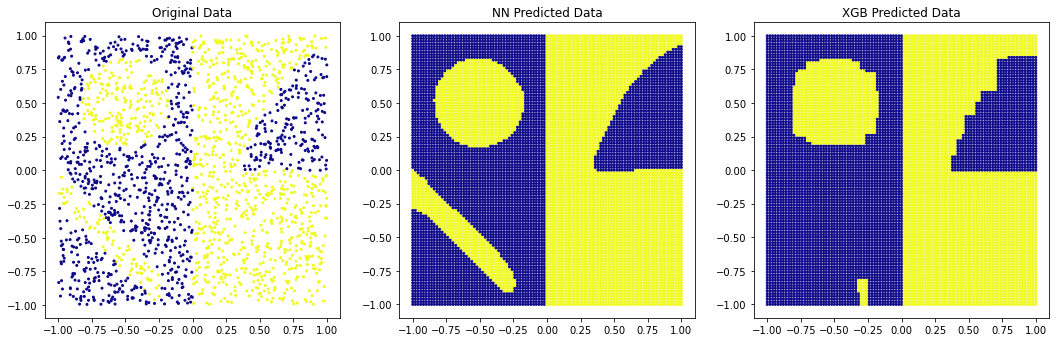

In [11]:
y_plot[y_plot>0.5]=1
y_plot[y_plot<0.5]=0



fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='plasma', s=4)
ax[0].scatter(x_test[:,0], x_test[:,1], c=y_test, cmap='plasma', s=4)
ax[0].set_box_aspect(1)
ax[0].set_title('Original Data')

ax[1].scatter(x_plot[:,0], x_plot[:,1], c=y_plot, cmap='plasma', s=4)
ax[1].set_box_aspect(1)
ax[1].set_title('NN Predicted Data')

ax[2].scatter(xg_x_plot[:,0]/2, xg_x_plot[:,1]/2, c=xg_y_plot, cmap='plasma', s=4)
ax[2].set_box_aspect(1)
ax[2].set_title('XGB Predicted Data')
plt.show()

We are interested in studying in which case it is better to use the XGBoost respect to a Neural Network, in particular with respect to the number of sampled data. For this reason we perform the training of the two models with different dataset (same generating function but different number of samples) and confront the accuracy of the two models.

In [12]:
N=[1e2, 500, 1e3, 1e4]  #List on the possible value of number of samples

#Performing the training for different values of number of samples
for n in N:
    #Generating the data
    x_train, y_train, x_test, y_test = gen_data(CASE=2,N=int(n),
                                                perc_train=perc_train,
                                                S=S)
    #XGBoost
    xg_x_plot, xg_y_plot, error_xgb =classify(XGBClassifier(seed=1,
                                                objective='binary:logistic',
                                                learning_rate=0.4,
                                                reg_lambda=0.001,
                                                n_estimators=3,
                                                n_jobs=-1),show=False)
    #NN
    x_train = Rescale(x_train, S)
    x_test = Rescale(x_test, S)
    nepochs=70
    model = compile_model(optimizer='RMSprop',
                          act_func='tanh',
                          neurons=10)
    history = model.fit(x_train, y_train,
                        epochs = nepochs,
                        batch_size = 100,
                        validation_data=(x_test,
                                         y_test),
                        verbose=0)
    print("Acc XGB:", (100-error_xgb)/100)
    print("Last Acc NN: {:.2f}".format(history.history['accuracy'][-1]))
    print("***************************")
    


N: 100 N_train: 80 CASE: 2
Acc XGB: 0.85
Last Acc NN: 0.71
***************************
N: 500 N_train: 400 CASE: 2
Acc XGB: 0.94
Last Acc NN: 0.71
***************************
N: 1000 N_train: 800 CASE: 2
Acc XGB: 0.925
Last Acc NN: 0.79
***************************
N: 10000 N_train: 8000 CASE: 2
Acc XGB: 0.9505
Last Acc NN: 0.89
***************************


As shown from the results of the previous cell, the XGBoost algorithm perform better with a low number of samples while when more data are available the Neural Network perform better.

# 2) XGB tuning

Now we try differente parameters for the XGBoost, changing $\lambda$, $\gamma$ and the number of estimators.

Generating the data

In [13]:
CASE=1
S=2
N=10000
perc_train=0.85
x_train, y_train, x_test, y_test = gen_data(CASE=2,N=N, perc_train=perc_train, S=S)

N: 10000 N_train: 8500 CASE: 2


In [14]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [15]:
lmb = [100,30,20,10,5,1,0.5,0.1]
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
n_est=[3,4,5,6,7,8]

optimizer = ['RMSprop']
act_func = ['tanh']
batch_size = [500]
nepochs = 70

# call Keras scikit wrapper
model_gridsearch = XGBClassifier(gamma=gam,
                                 n_estimators=n_est,
                                 reg_lambda=lmb)

# define parameter dictionary
param_grid = dict(gamma=gam,
                  reg_lambda=lmb,
                  n_estimators=n_est)

print(param_grid)


# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=4)

{'gamma': [0.0, 1.0, 2.0, 4.0, 10.0, 20.0, 40.0, 100.0, 200.0], 'reg_lambda': [100, 30, 20, 10, 5, 1, 0.5, 0.1], 'n_estimators': [3, 4, 5, 6, 7, 8]}


In [16]:
grid_result = grid.fit(x_train, y_train)

dgs = pd.DataFrame(grid_result.cv_results_)

print(f'The best parameters are:{grid_result.best_params_},\nwhith a score of {grid_result.best_score_}')

The best parameters are:{'gamma': 0.0, 'n_estimators': 8, 'reg_lambda': 1},
whith a score of 0.9615294117647059


errors: 3.00%


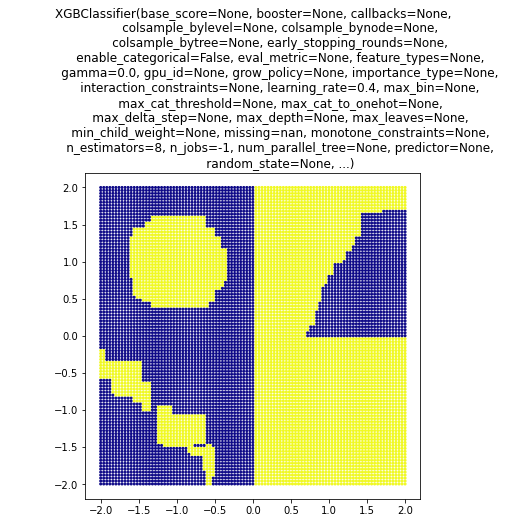

num_trees= 8


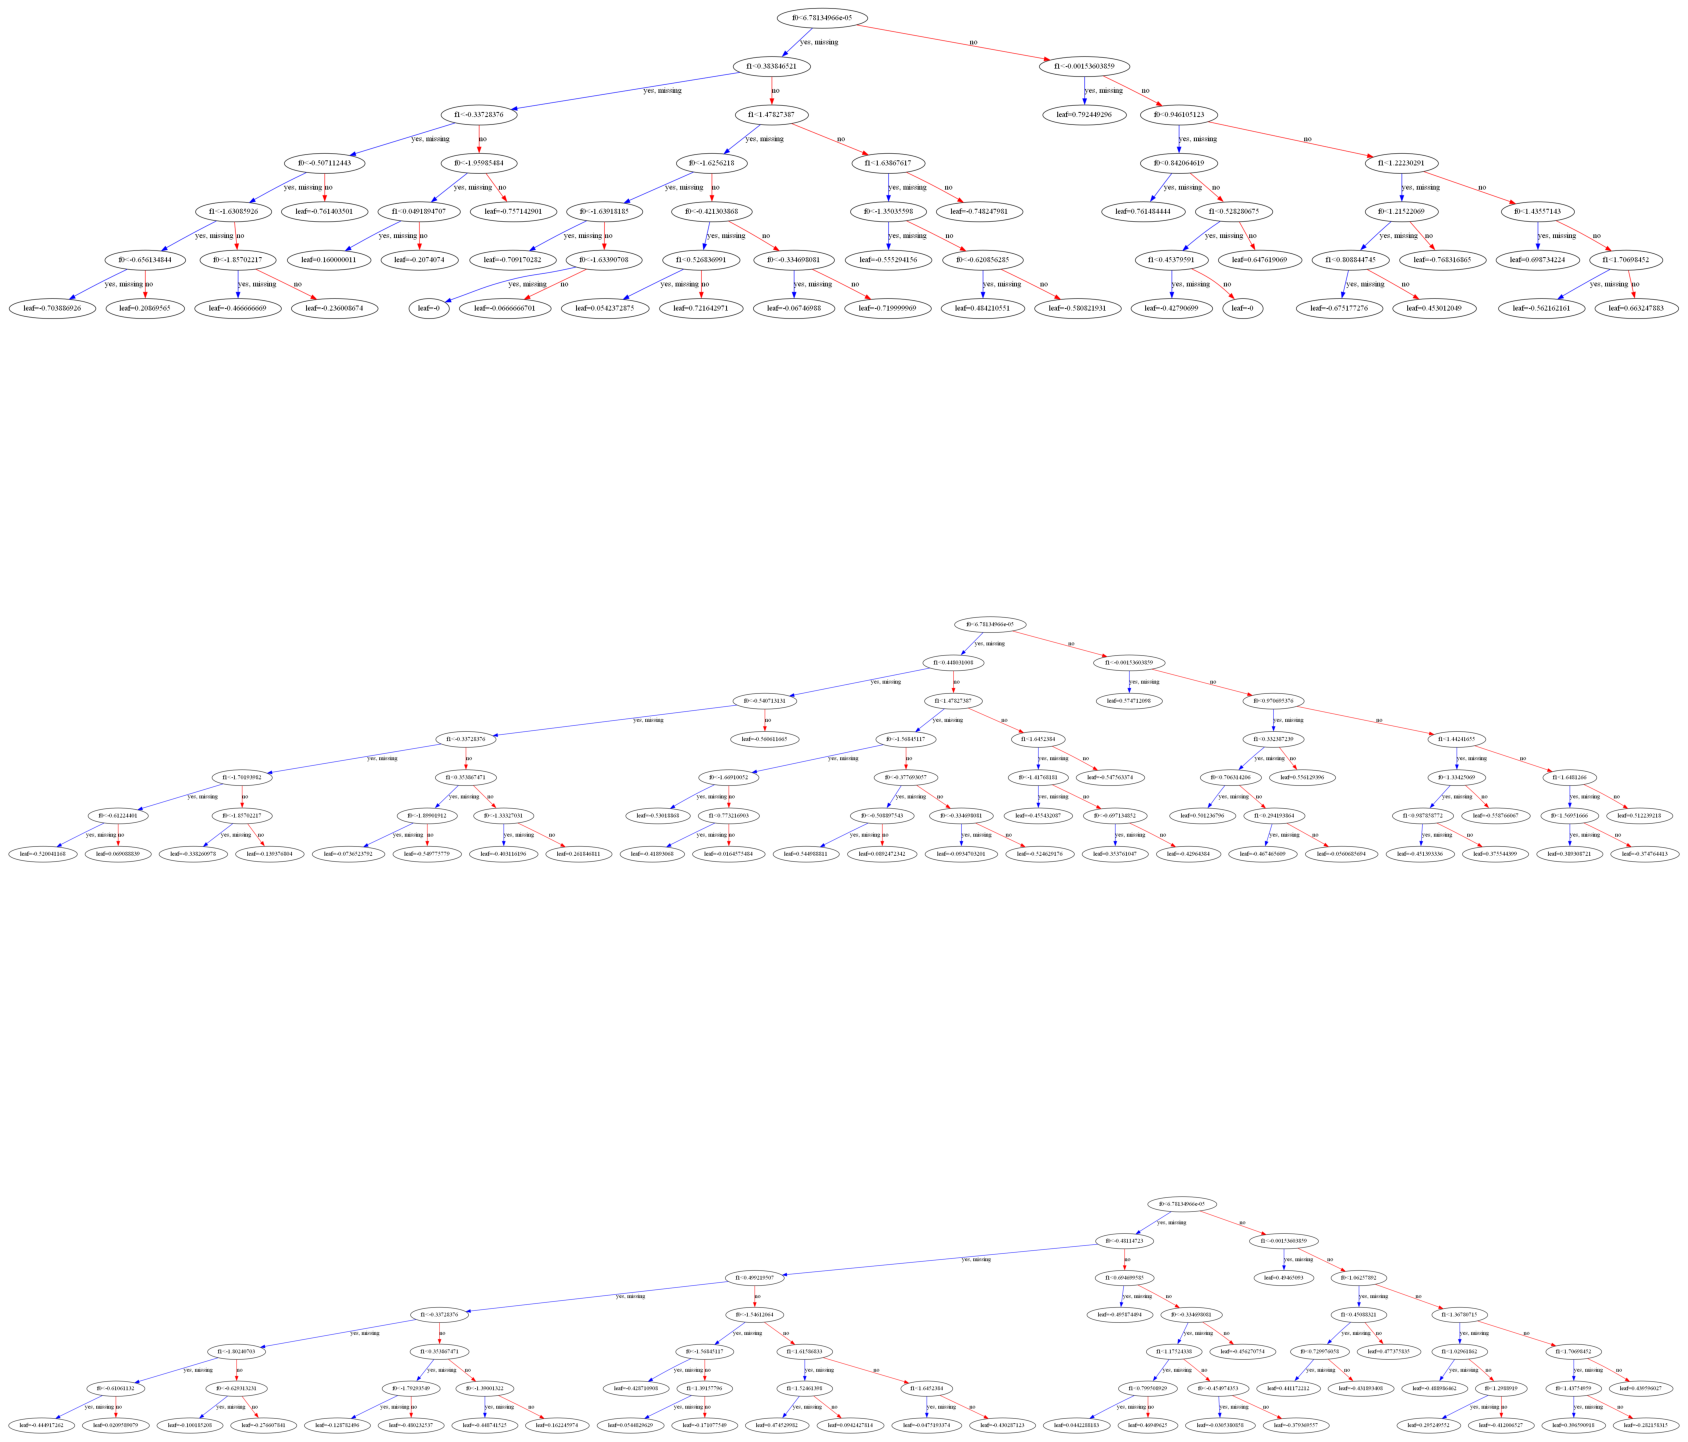

In [17]:
xg_x_plot, xg_y_plot, _=classify(XGBClassifier(seed=1,
                                               objective='binary:logistic',
                                               learning_rate=0.4,
                                               reg_lambda=5,
                                               n_estimators=8,
                                               gamma=0.0,
                                               n_jobs=-1), show=True)

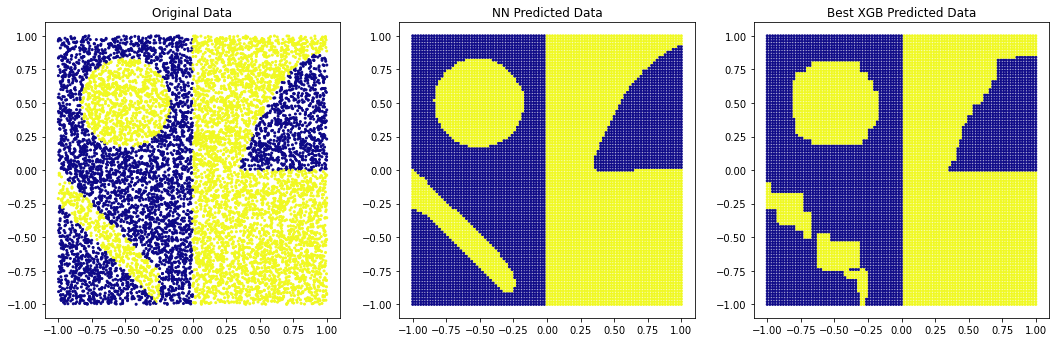

In [18]:
x_train = Rescale(x_train, S)
x_test = Rescale(x_test, S)

y_plot[y_plot>0.5]=1
y_plot[y_plot<0.5]=0



fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='plasma', s=4)
ax[0].scatter(x_test[:,0], x_test[:,1], c=y_test, cmap='plasma', s=4)
ax[0].set_box_aspect(1)
ax[0].set_title('Original Data')

ax[1].scatter(x_plot[:,0], x_plot[:,1], c=y_plot, cmap='plasma', s=4)
ax[1].set_box_aspect(1)
ax[1].set_title('NN Predicted Data')

ax[2].scatter(xg_x_plot[:,0]/2, xg_x_plot[:,1]/2, c=xg_y_plot, cmap='plasma', s=4)
ax[2].set_box_aspect(1)
ax[2].set_title('Best XGB Predicted Data')
plt.show()